In [ ]:
import numpy as np
import pandas as pd
import itertools
from collections import Counter

import missingno as msno

from sklearn.svm import SVC
from scipy.stats import loguniform
import matplotlib.pyplot as plt

from scipy.stats import loguniform, uniform

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    learning_curve,
    validation_curve,
    train_test_split,
    cross_validate,
    GridSearchCV,
    RepeatedStratifiedKFold,
)
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as IMBPipeline

import warnings

warnings.filterwarnings('ignore')

In [ ]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

# Information

## Project Details

You can find all information related to the project in README.md file.

# Data handling

## Analysing

In [ ]:
df = pd.read_csv('data/raw/creditcard.csv',delimiter=',')

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

The dataset consists of 30 columns, with a time format in seconds spanning 48 hours. The 'Amount' column denotes the transaction value without currency details. The 'Class' column is binary (0 for non-fraud cases, 1 for fraud cases). The 'V' columns contain anonymous data for confidentiality reasons, they could be anything such as names, birth dates, card numbers, etc.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Class Comparison

Lets check how imbalanced our data is, as we can observe the minority class in other words the fraud cases is approximately 0.17% of the whole dataset indicating that our data is highly imbalanced, means that we need to downsample our majority class in order to have equal counts for both. Upsampling would only bring us more computational complexity and time and it would break the efficiency when it comes to large datasets with high class imbalance.

In [ ]:
counts = y.value_counts()
percentages = y.value_counts(normalize=True)

print("Counts:")
print(counts)
print("\nPercentages:")
print(percentages * 100)

Counts:
0    284315
1       492
Name: Class, dtype: int64

Percentages:
0    99.827251
1     0.172749
Name: Class, dtype: float64


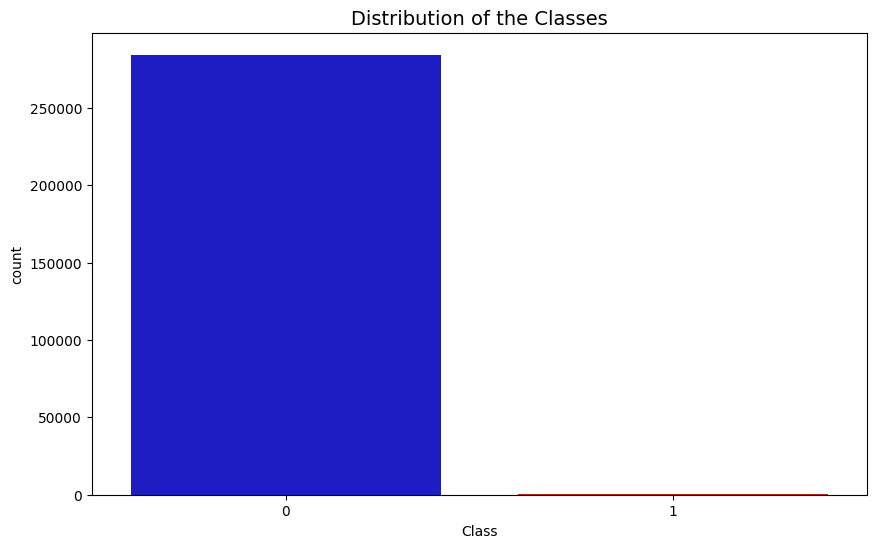

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df, palette=["#0101DF", "#DF0101"])
plt.title('Distribution of the Classes', fontsize=14)
plt.show()

For downsampling we can use RandomUnderSampler(), this is what our classes look like when balanced, grants better comparison for the model and efficiency.

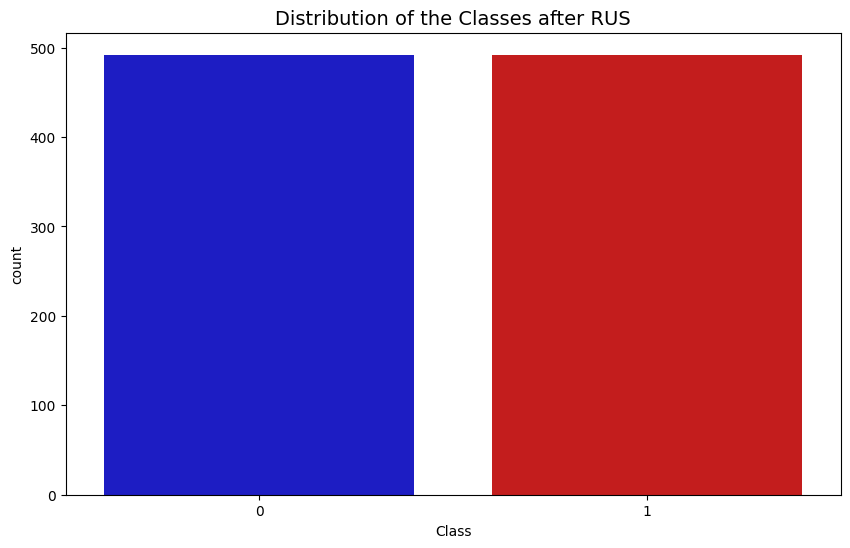

In [ ]:
rus = RandomUnderSampler(sampling_strategy=1.0)
X_res, y_res = rus.fit_resample(X, y)

df_res = pd.concat([X_res, y_res], axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df_res, palette=["#0101DF", "#DF0101"])
plt.title('Distribution of the Classes after RUS', fontsize=14)
plt.show()

## Corruption

In [ ]:
X['V3'] = add_missing(X['V3'], 0.12)
X['V27'] = add_missing(X['V27'], 0.17)
X['V18'] = add_missing(X['V18'], 0.1)
X['V9'] = add_missing(X['V9'], 0.6) 
X['Amount'] = add_missing(X['Amount'], 10000)
X = add_missing_rows(X, 0.01)

In [ ]:
df = pd.concat([X, y], axis=1)

df.to_csv('data/processed/creditcard_corrupted.csv', index=False)

# Preprocessing

## Data Cleaning

Here we drop the missing rows, as we understand from the graph below, missing rows does not contain any data so we do not need them. 

Then we drop the column 'V9' since it contains ">50%" missing, it is not possible to fill it with mean values without harming the natural structure.

<AxesSubplot: >

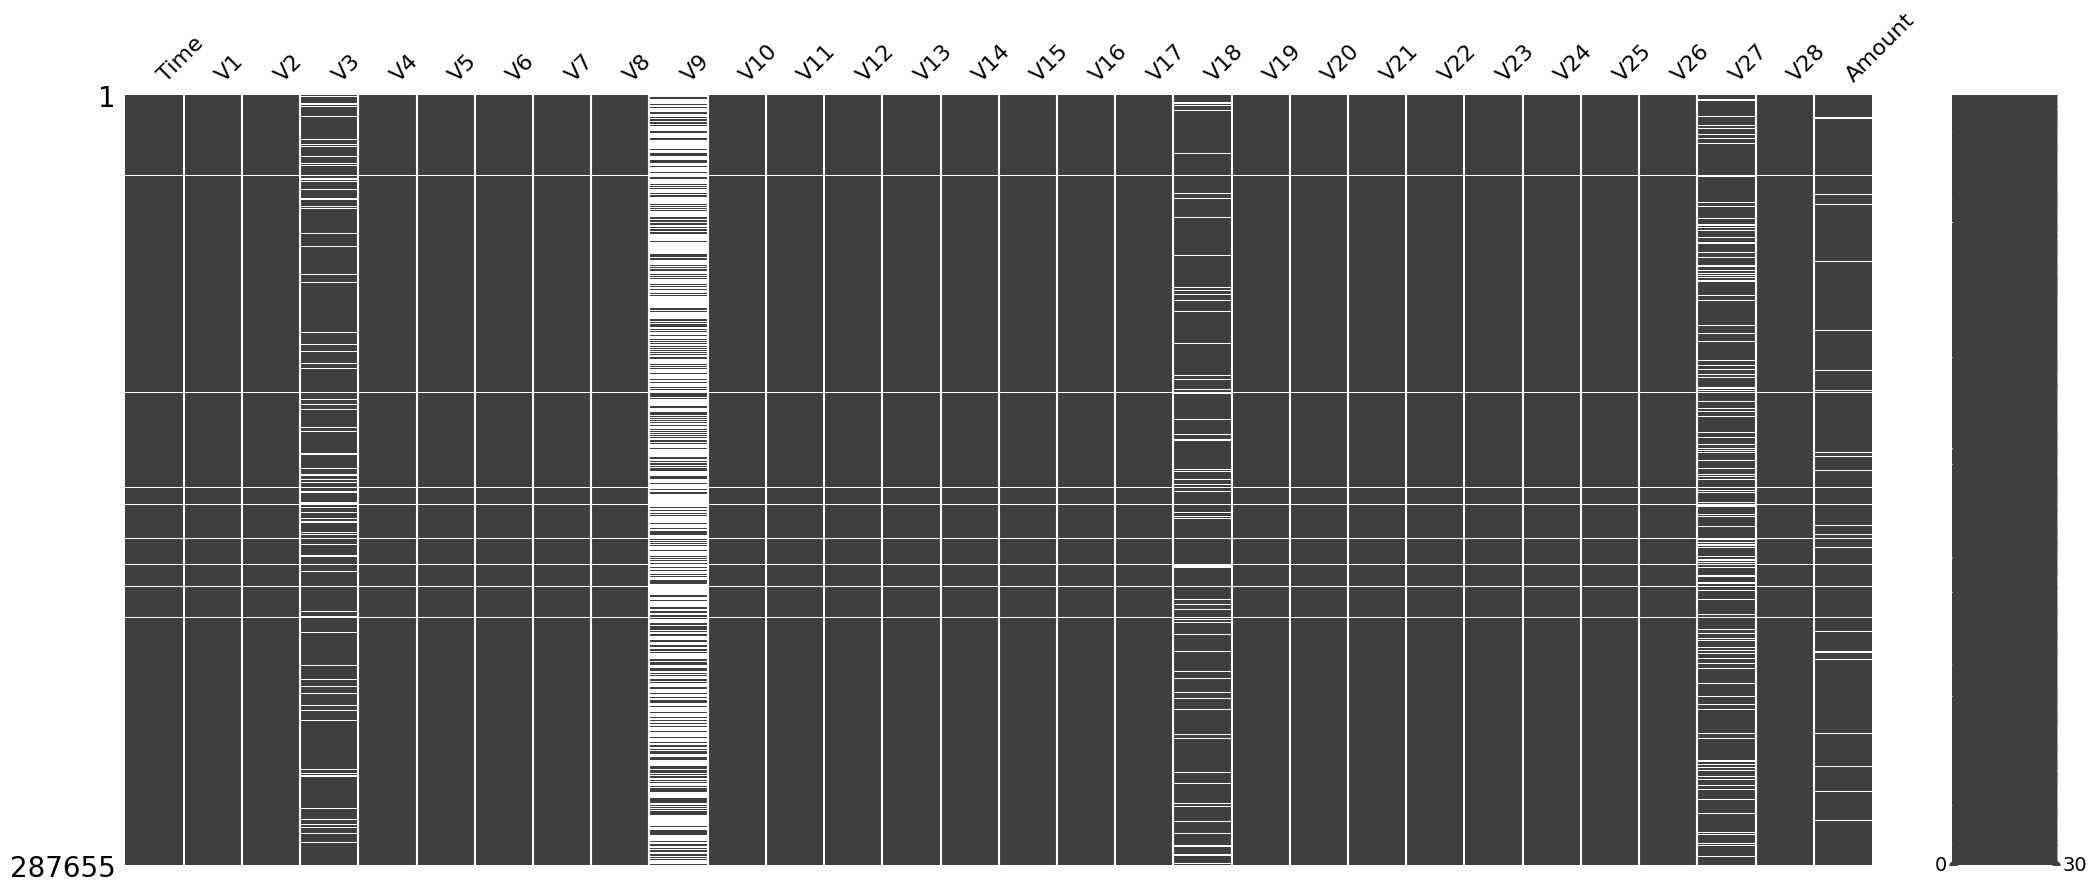

In [ ]:
msno.matrix(X)

In [ ]:
rows = X.isnull().all(axis=1).sum()
print("Missing Rows Before Cleaning:", rows)

Missing Rows Before Cleaning: 2848


In [ ]:
# Drop all the rows that has completely missing data
X = X.dropna(how='all')

In [ ]:
rows_after = X.isnull().all(axis=1).sum()
print("Missing Rows After Cleaning:", rows_after)

Missing Rows After Cleaning: 0


<AxesSubplot: >

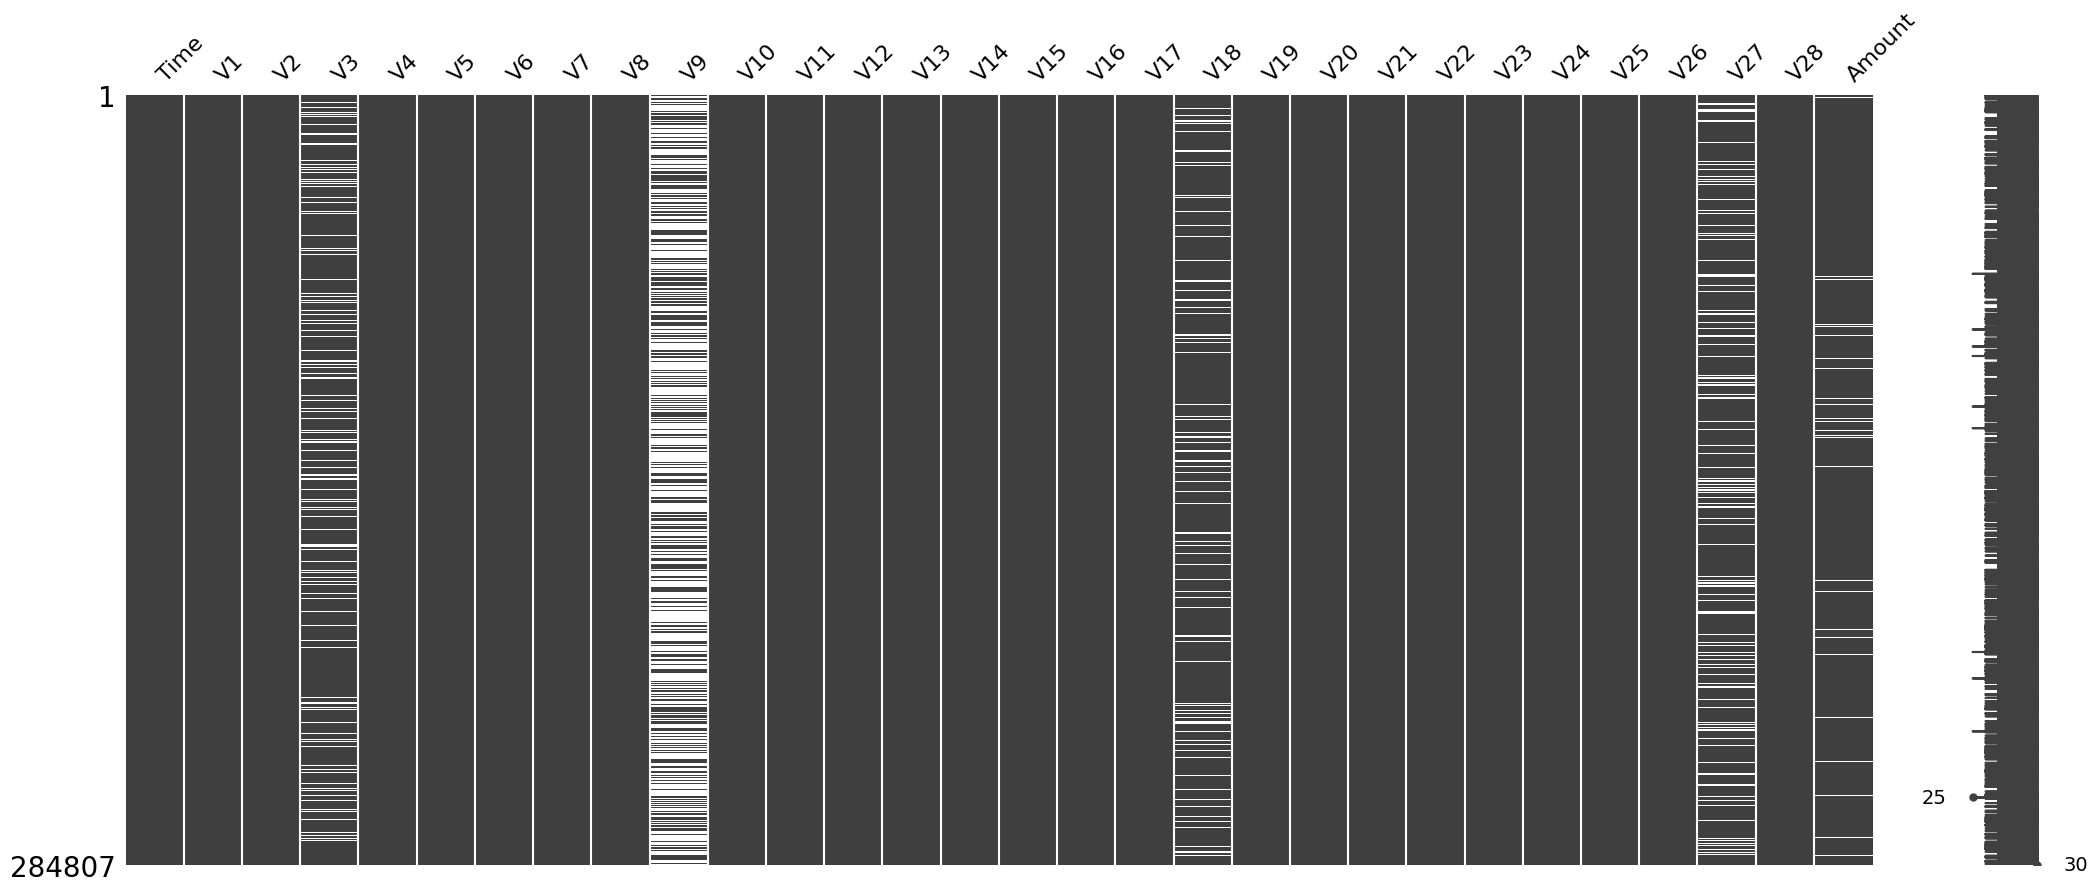

In [ ]:
msno.matrix(X)

After getting rid of rows that has completely missing values, by checking the graph above we see that columns 'V3', 'V9', 'V18', 'V27', 'Amount' has missing values. Working with columns is a little bit different than the rows. We have to fill in those missing values in the columns using the method of choice, depending on the type of data we have. In our case we have all numerical values with V columns and Amount column we can use mean value However, before filling it up we must consider what percentage of our column is missing. Filling a column with more than 45-50% missing data could be harmful for the natural structure of the data we could end up having misleading values in the column. Lets check more precisely in which columns we have missing data and what is the percentage.

As we understand from the code down below, it is safe to drop column 'V9', and we do not have any other missing values but 'V3', 'V18', 'V27', 'Amount', thus by checking their missing percentages they are all safe to fill.

In [ ]:
miss_cols = X.isnull().mean() * 100

for column_name, missing_percentage in miss_cols.items():
    if missing_percentage > 0.0:
        print(f"{column_name}: {missing_percentage}%")

V3: 11.999705063428918%
V9: 59.99992977700689%
V18: 9.999754219524098%
V27: 16.99993328815654%
Amount: 3.511149655731776%


Goodbye column 'V9'.

In [ ]:
X = X.drop('V9', axis=1)

## Data Transformation Pipeline

After cleaning of empty values and exceedingly empty columns, here we must apply transformation to our data, because we still have missing values in the columns and scale differences.

1. pipeline_v: In columns from 'V1' to 'V28' due to confidentiality issues data is PCA applied and scaled. That's why we use only simple imputer to add mean values for missing data.

2. pipeline_amount: Now we must apply scaler, otherwise our 'Time' and 'Amount' columns will not have any similarity with other columns so associating them going to be harder. As we did before we are also filling the empties with mean values.

3. final_transformation: We apply our changes to desired columns, by using the parameter named remainder we let other untouched columns passthrough since modification is not necessary.

In [ ]:
pipeline_v = Pipeline([
    ('imp', SimpleImputer(strategy='mean')), 
])

pipeline_amount = Pipeline([    
    ('imp', SimpleImputer(strategy='mean')), 
    ('scaler', RobustScaler()),
])


final_transformation = ColumnTransformer(transformers=[
    ('amount_time', pipeline_amount, ['Amount', 'Time']),
    ('all_v', pipeline_v, ['V3', 'V18', 'V27' ])
],
remainder='passthrough',
verbose_feature_names_out=False,
sparse_threshold=0
)

Scaling problems due to unscaled data, refer to the graph below to see the comparison. Time and Amount indeed requires application of scaler.

In [ ]:
X[['Time', 'Amount', 'V1', 'V15','V28']].head()

,Time,Amount,V1,V15,V28
0,0.0,149.62,-1.359807,1.468177,-0.021053
1,0.0,2.69,1.191857,0.635558,0.014724
2,1.0,NaN,-1.358354,2.345865,-0.059752
3,1.0,123.50,-0.966272,-0.631418,0.061458
4,2.0,69.99,-1.158233,0.175121,0.215153


Here we have a small demo of what happens after transformations applied to our Time and Amount columns

In [ ]:
# Just for check to see what happens after transformation
X_copy = X.copy()

X_trans = final_transformation.fit_transform(X_copy)

df_trans = pd.DataFrame(X_trans, columns=X_copy.columns)

df_trans[['Time', 'Amount', 'V1', 'V15','V28']].head()

,Time,Amount,V1,V15,V28
0,1.515557,-0.021053,-0.994983,-0.617801,-0.189115
1,-0.269173,0.014724,-0.994983,1.065235,0.125895
2,0.771762,-0.059752,-0.994972,0.066084,-0.139097
3,1.198282,0.061458,-0.994972,0.178228,-0.221929
4,0.548307,0.215153,-0.994960,0.538196,0.502292


One last step of the check if the transformation applied correct.

In [ ]:
df_trans.isnull().any().sum()

0

<AxesSubplot: >

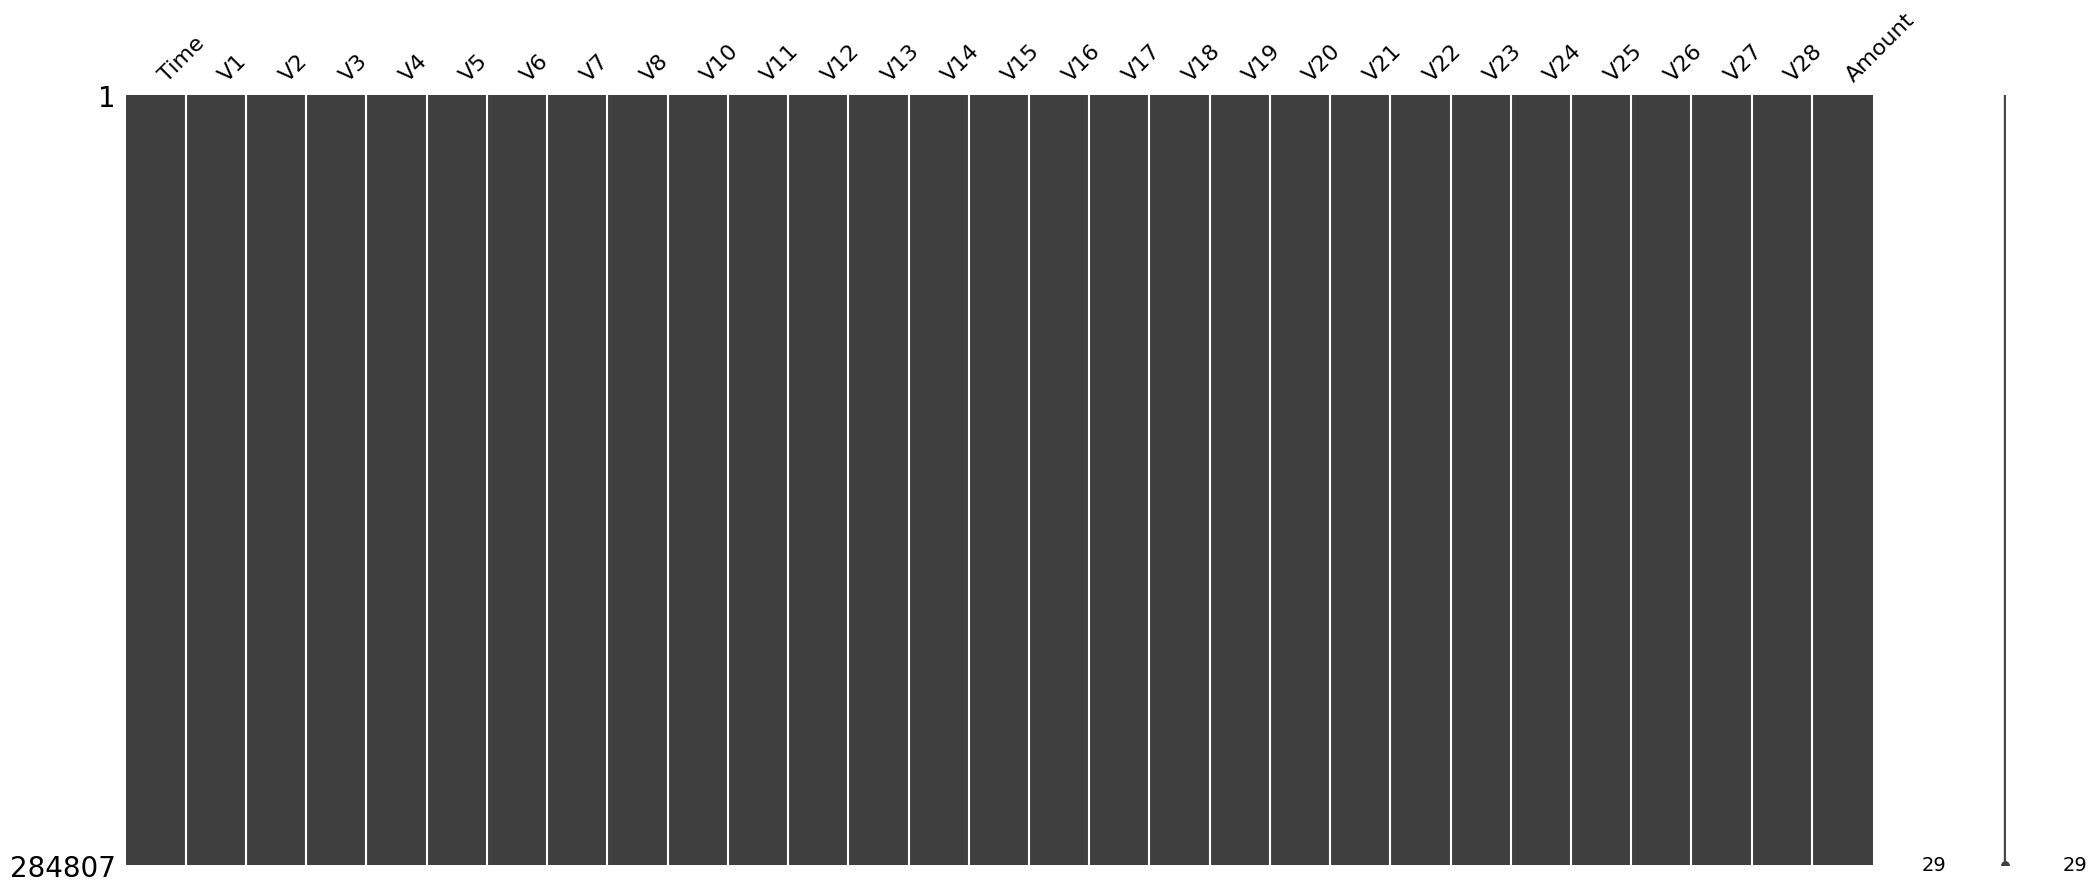

In [ ]:
msno.matrix(df_trans)

# Training and Test sets

Everything is good to move a step forward and separate our data into training and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=30, shuffle=True)

It is important that we must not sample the complete data before splitting, so we apply our sampling method meanwhile fitting to prevent possible outcomes. If we would downsample our data before splitting, it would cause problems, test and training wise. Since we have small bits of data in our minority class after downsampling we also will have small amount in majority class. However, we want to have large amount of data in our test set to have better results, otherwise it could overfit.

# Model Selection

## Sanity Check

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', RandomUnderSampler(sampling_strategy=1.0)),
    ('dim_reduction', PCA(n_components=2, random_state=42)),
    ('classifier', LogisticRegression())
])

In [ ]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('amount_time',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Amount', 'Time']),
                                                 ('all_v',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['V3', 'V18', 'V27'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomUnderSampler(sampling_strategy=1.0)),
                ('dim_reduction', PCA(n_components=2, random_state=42)),
                ('classifier', LogisticRegression())])

In [ ]:
model_pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

## Configurations

sampler_configs : Preferably we placed only downsampling methods, otherwise it takes forever to train it if upsampled. We tried with NearMiss() and RandomUnderSampler(), however in order to reduce complexity of the configuration we only kept RandomUnderSampler().

dim_reduction_configs : Either none or PCA(). We already know that our data is PCA() applied, however it is only applied to the V features not to the Time and Amount features so maybe it is possible that it might have good results with it so we decided to keep PCA().

classifier_configs : Choice of classifiers are completely trial and error based. These classifiers are mainly taken into account because of our binary classification problem.

Overall Tuning : Hyperparameter tuning is like an artistic piece of work, a little bit of this a little bit of that till we get the best result. Adjust some values and start praying while it's being trained. Sometimes it is better to keep it simple.

In [ ]:
sampler_configs = [
    {
        "sampler": [RandomUnderSampler()],
        "sampler__sampling_strategy": [1.0]
    },
]

dim_reduction_configs = [
    
    {
        'dim_reduction': [None],
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [2],
        'dim_reduction__random_state': [42]
    },
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__penalty': ['l1', 'l2']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': list(range(2,5,1)),
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_depth': list(range(2,4,1)),
        'classifier__min_samples_leaf': list(range(5,7,1))
    }
]

In [ ]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 8'

In [ ]:
all_configs[:2]

[{'sampler': [RandomUnderSampler()],
  'sampler__sampling_strategy': [1.0],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__penalty': ['l1', 'l2']},
 {'sampler': [RandomUnderSampler()],
  'sampler__sampling_strategy': [1.0],
  'dim_reduction': [None],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [2, 3, 4],
  'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]

## Training

Even though GridSearchCV() is computationally more expensive because of its exhaustive searching nature, it returns better results using it with 'recall' scoring. We tried with both GridSearchCV() and RandomSearchCV(), and also scoring of 'f1'. However, GridSearchCV() and recall does better job. 

### Why GridSearchCV()?

GridSearchCV() Cons

GridSearchCV() Pros

- Computationally expensive 

- Good for small amount hyperparameters

- Tries all combinations of the hyperparameters to find the best result

- Finds optimal parameters which for best results

- Time consuming

- Fixed set of hyperparameters, not flexible

RandomSearchCV() Cons

RandomSearchCV() Pros

- Computationally less expensive 

- Good for large amount hyperparameters

- Randomly selects the combination of hyperparameters

- More efficient to find a result

- Less time consuming

- More distribution of hyperparameter values, flexible

In our case we must be precise and find the optimal results in order to prevent losing our clients, since we know our case well and downgraded amount of configurations to be used, then it will not cause high performance and time consuming issues, thus we will find our best results in the given range of combinations by using GridSearchCV optimally.

### Why Recall?

Recall scoring, also known as sensitivity, helps in our case way more than the other scorings, because we have great amount of true positive examples in our data rather than false negatives, and we are looking for a way to spot false negatives by correctly identifying true positives, that's why we used recall scoring in order to prevent false flagging of legitimate transactions. 

Imagine of a real life example where the person who is programming this model works at a banking company, outcomes of making a false prediction on a decent customer would ruin the reputation of the firm rapidly and they would loose clients. 

In [ ]:
gs = GridSearchCV(
        model_pipeline,
        param_grid=all_configs,
        n_jobs=-1,
        cv=5,
        scoring='recall'
)

For faster results, run it locally. Sorry for the runtime in DeepNote.

In [ ]:
scores = cross_validate(
        gs, 
        X_train, 
        y_train, 
        scoring='recall', 
        cv=5, 
        return_estimator=True, 
        verbose=3
) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.913 total time= 2.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[CV] END ......................................., score=0.913 total time= 2.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s
[CV] END ......................................., score=0.884 total time= 2.2min
[CV] END ......................................., score=0.913 total time= 2.2min
[CV] END ......................................., score=0.897 total time= 2.2min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.0min finished


## Choosing the Best Model

When it comes to choosing the best model we need to consider firstly, the best result on the test set

Recall on training set: 0.9447674418604651, Recall on test set: 0.9054054054054054

Recall on training set: 0.958953488372093, Recall on test set: 0.8318918918918919

Recall on training set: 0.8982558139534884, Recall on test set: 0.8851351351351351

Recall on training set: 0.9302325581395349, Recall on test set: 0.8986486486486487

Secondly, we need to select the find the best result on the training set, but while doing that we also need to see the difference between the training and the test set, we must not trust the result if it has a lot of difference.

As a result we could select the model with this result, difference is less and both values are good.

Recall on training set: 0.9447674418604651, Recall on test set: 0.9054054054054054


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomUnderSampler(sampling_strategy=1.0)
None
SVC(kernel='linear') {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.9130434782608695
----------
RandomUnderSampler(sampling_strategy=1.0)
None
LogisticRegression(solver='saga') {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.9130434782608695
----------
RandomUnderSampler(sampling_strategy=1.0)
None
LogisticRegression(solver='saga') {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto'

Note : As we mentioned earlier, PCA() is applied in the original dataset, we just placed it in our configuration just in case, however most of the times dim_reduction is None.

In [ ]:
for estimator in scores['estimator']:
    estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    recall_train = recall_score(y_train, pred_train)
    recall_test = recall_score(y_test, pred_test)
    print(f'Recall on training set: {recall_train}, Recall on test set: {recall_test}')

Recall on training set: 0.936046511627907, Recall on test set: 0.8986486486486487
Recall on training set: 0.9186046511627907, Recall on test set: 0.8986486486486487
Recall on training set: 0.9156976744186046, Recall on test set: 0.8851351351351351
Recall on training set: 0.9244186046511628, Recall on test set: 0.8918918918918919
Recall on training set: 0.9244186046511628, Recall on test set: 0.8716216216216216


Here we must place the best possible resulting model from two code blocks before

Last runtime we had our best result with this parameters in our model

RandomUnderSampler(sampling_strategy=1.0)
None
SVC(kernel='linear') {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

So we place it in the block down below as demonstrated, of course before everything we must apply the transformation that we have done earlier in our code.

In [ ]:
best_model_pipeline = IMBPipeline(
    [
        ("trans", final_transformation),
        ("sampler", RandomUnderSampler(sampling_strategy=1.0)),
        #("dim_reduction", PCA(n_components=2, random_state=42)),
        #("classifier", LogisticRegression(solver="saga", penalty="l1")),
        ("classifier", SVC(kernel="linear")),
    ]
)

Here in this block we must use the parameters depending on our classifier, as I commented out to give the list of parameters for evaluation of perceptron we would use different values, classifiers might have different values of parameters so we can change it depending on our result.

In [ ]:
params = {
    #'classifier__C': uniform(loc = 15, scale = 60)
    #'classifier__alpha': uniform(loc = 0.0001, scale = 0.001),  # perceptron
    'classifier__C': [0.1, 1, 10, 100, 1000]

}

In [ ]:
gs_best = GridSearchCV(
    estimator = best_model_pipeline,
    param_grid = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    scoring='recall'
)

In [ ]:
gs_best.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('amount_time',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['Amount',
                                                                          'Time']),
                                                                        ('all_v',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         ['V3',
                                                                          'V18',
                                                                          'V27'])],
                                                          verbose_feature_names_out=False)),
                                       ('sampler',
                                        RandomUnderSampler(sampling_strategy=1.0)),
                                       ('classifier', SVC(kernel='linear'))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000]},
             scoring='recall')

In [ ]:
recall_score(y_test, gs_best.best_estimator_.predict(X_test))

0.8918918918918919

In [ ]:
cls = gs_best.best_estimator_

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
                    cls,
                    X=X_train,
                    y=y_train,
                    train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                    cv = 5,
                    n_jobs = -1,
                    scoring = 'recall',
                    shuffle = False
                    )

In [ ]:
train_scores.shape
test_scores.shape

(11, 5)

(0.6, 1.03)

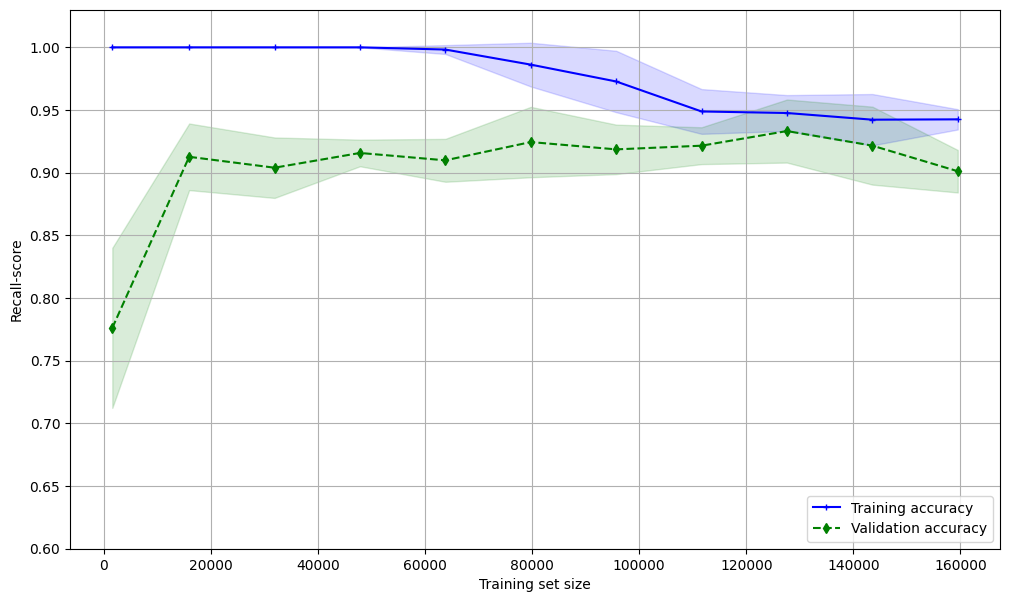

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('Recall-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

In [ ]:
range_C = [0.1,1,10,100,1000]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='recall'
)

(0.05, 100)

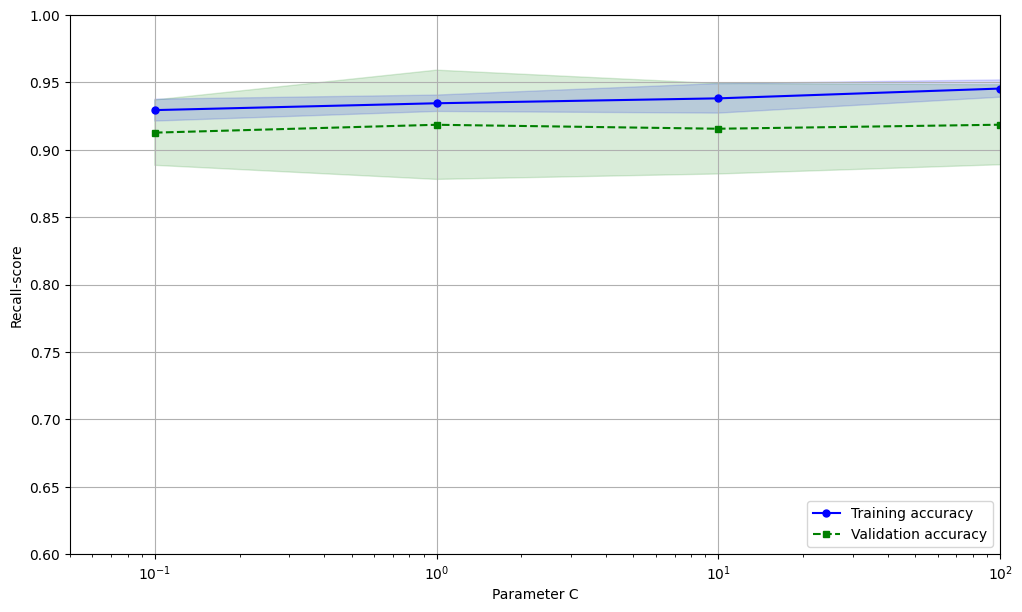

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('Recall-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.0])
ax.set_xscale('log')
ax.set_xlim([0.05,100])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b7081f18-9855-43a4-b91d-c9c6c34e892f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>